#### Business Problem
On the occasion of World Mental Health Day this October 10th, your organization has stepped in to help its employees plan their weekly calendars appropriately so as to prevent burning out. Your task, as a Machine Learning engineer, is to build a Machine Learning model that predicts burnout rate based on numerous factors such as WFH setup, resources, mental fatigue score, and the like.
#### https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-predict-burnout-rate/

#### Dataset

The dataset consists of parameters such as date of joining, gender, company type, WFH setup availability, designation, resource allocation, and mental fatigue score.

The benefits of practicing this problem by using unsupervised Machine Learning techniques are as follows:

This challenge encourages you to apply your Machine Learning skills to build models that can predict the burnout rate in employees.
This challenge will help you enhance your knowledge of regression. Regression is one of the basic building blocks of Machine Learning.
We challenge you to build a model that predicts the burnout rate among employees.

In [1]:
import pandas as pd
import pandasql as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp 
from pandas_profiling import ProfileReport
import scipy.stats as stats

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
from sklearn import metrics
import xgboost
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.decomposition import FactorAnalysis
from sklearn import preprocessing
import shap 
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import tree

In [2]:
df = pd.read_csv("C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\train.csv")

In [3]:
# Store the records with missing 'Burn Rate' in a separate dataframe
# We will see how to process this file later
df1 = df[df['Burn Rate'].isna()]
df1.head(5)
# Dropping the Burn Rate before saving file to make it identical to test.csv
df1.drop('Burn Rate',axis=1,inplace=True)
# Save the file
df1.to_csv('C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\df1.csv', index=False)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Data Preprocessing

In [4]:
df.shape

(22750, 9)

In [5]:
df.head(2)

Employee ID Date of Joining  Gender Company Type  \
0  fffe32003000360033003200      2008-09-30  Female      Service   
1      fffe3700360033003500      2008-11-30    Male      Service   

  WFH Setup Available  Designation  Resource Allocation  Mental Fatigue Score  \
0                  No          2.0                  3.0                   3.8   
1                 Yes          1.0                  2.0                   5.0   

   Burn Rate  
0       0.16  
1       0.36

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [7]:
# Convert to datetime column
df[["Date of Joining"]] = df[["Date of Joining"]].apply(pd.to_datetime)

In [8]:
# Subtract from today and create a new column 'Employment Duration'
dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
df['Employment Duration'] = dt - pd.to_datetime( df['Date of Joining'])

df.drop('Date of Joining',axis=1,inplace=True)

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


In [9]:
#Extract the number of days from timedelta64 object
# Convert to years
df['Employment Duration'] = df['Employment Duration'].astype('timedelta64[D]')
df['Employment Duration'] = df['Employment Duration']/365

In [10]:
df.head(2)

Employee ID  Gender Company Type WFH Setup Available  \
0  fffe32003000360033003200  Female      Service                  No   
1      fffe3700360033003500    Male      Service                 Yes   

   Designation  Resource Allocation  Mental Fatigue Score  Burn Rate  \
0          2.0                  3.0                   3.8       0.16   
1          1.0                  2.0                   5.0       0.36   

   Employment Duration  
0            12.098630  
1            11.931507

In [11]:
#Profile report
#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
#profile.to_file("C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\profile_report.html")

In [12]:
#profile

In [13]:
# Employee ID is irrelevant data for linear regression, so dropping the variable.
df.drop('Employee ID',axis=1,inplace=True)

In [14]:
# Convert into categorical variables

df['Designation'] = df['Designation'].astype('category')
df['Gender'] = df['Gender'].astype('category')
df['Company Type'] = df['Company Type'].astype('category')
df['WFH Setup Available'] = df['WFH Setup Available'].astype('category')
df['Resource Allocation'] = df['Resource Allocation'].astype('category')

#### Exploratory Data Analysis

In [15]:
df.info()
df['Burn Rate'].plot.hist(bins=20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                22750 non-null  category
 1   Company Type          22750 non-null  category
 2   WFH Setup Available   22750 non-null  category
 3   Designation           22750 non-null  category
 4   Resource Allocation   21369 non-null  category
 5   Mental Fatigue Score  20633 non-null  float64 
 6   Burn Rate             21626 non-null  float64 
 7   Employment Duration   22750 non-null  float64 
dtypes: category(5), float64(3)
memory usage: 645.3 KB


<AxesSubplot:ylabel='Frequency'>

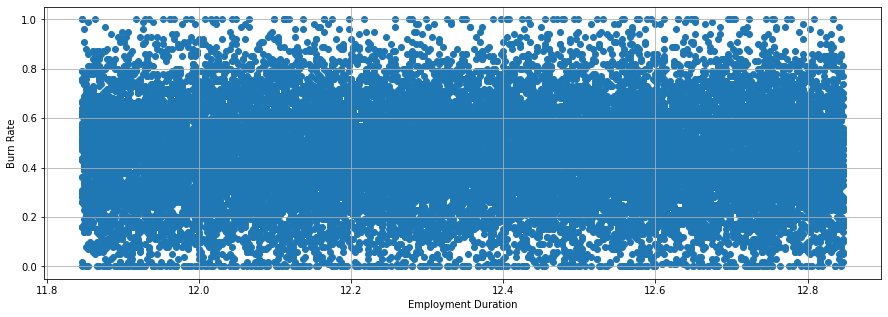

In [16]:
plt.subplots(figsize=(15,5))
plt.scatter(df['Employment Duration'],df['Burn Rate'])
plt.xlabel('Employment Duration')
plt.ylabel('Burn Rate')
plt.grid()
plt.show()

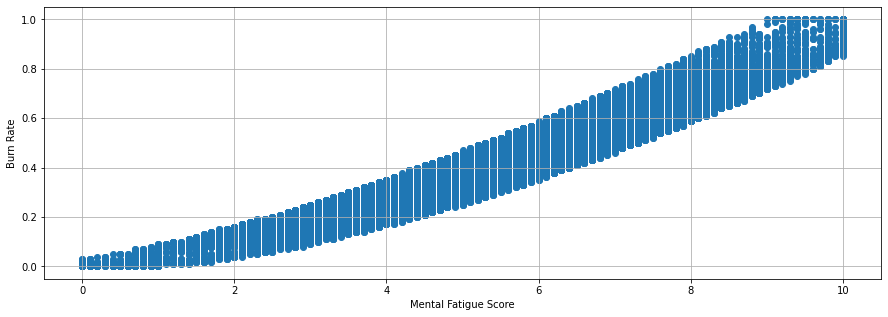

In [17]:
plt.subplots(figsize=(15,5))
plt.scatter(df['Mental Fatigue Score'],df['Burn Rate'])
plt.xlabel('Mental Fatigue Score')
plt.ylabel('Burn Rate')
plt.grid()
plt.show()

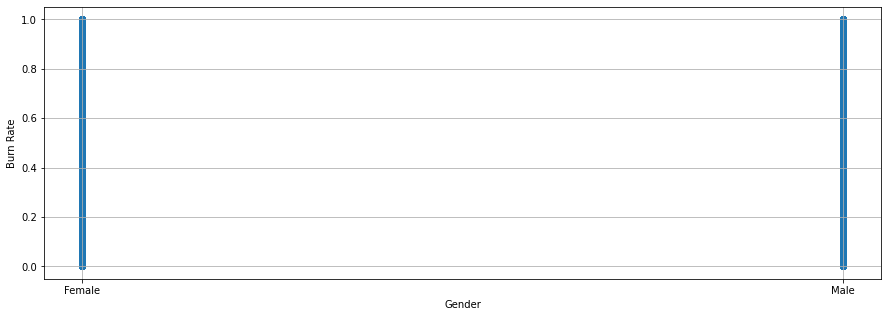

In [18]:
plt.subplots(figsize=(15,5))
plt.scatter(df['Gender'],df['Burn Rate'])
plt.xlabel('Gender')
plt.ylabel('Burn Rate')
plt.grid()
plt.show()


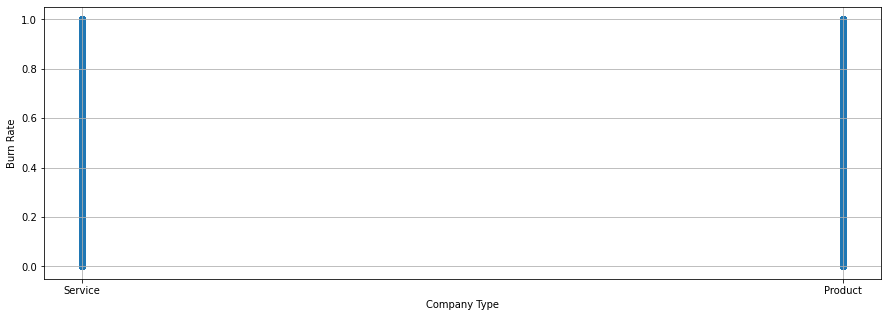

In [19]:
plt.subplots(figsize=(15,5))
plt.scatter(df['Company Type'],df['Burn Rate'])
plt.xlabel('Company Type')
plt.ylabel('Burn Rate')
plt.grid()
plt.show()

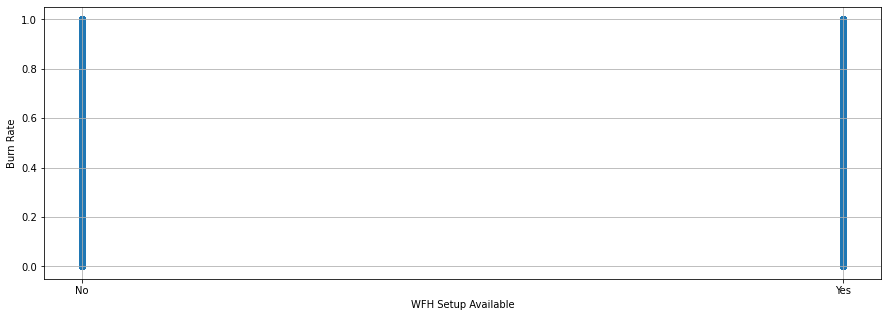

In [20]:
plt.subplots(figsize=(15,5))
plt.scatter(df['WFH Setup Available'],df['Burn Rate'])
plt.xlabel('WFH Setup Available')
plt.ylabel('Burn Rate')
plt.grid()
plt.show()

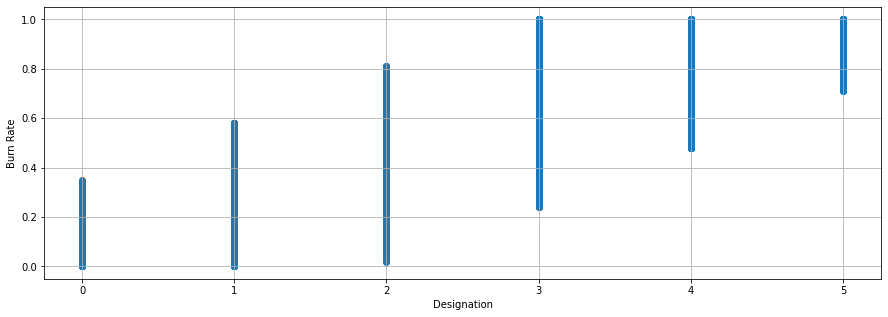

In [21]:
plt.subplots(figsize=(15,5))
plt.scatter(df['Designation'],df['Burn Rate'])
plt.xlabel('Designation')
plt.ylabel('Burn Rate')
plt.grid()
plt.show()

#### Splitting the variables into Categorical & Numeric

In [22]:
#****************************** Creating List *****************************************************************************#

# Categorical List contains categorical variables
cat_var=['Gender','Company Type','WFH Setup Available','Designation','Resource Allocation']


# Numerical List= Contains numerical variables..
num_var=[]
for var in df.columns:
    if var not in cat_var:
        num_var.append(var)

In [23]:
num_var
cat_var

['Gender',
 'Company Type',
 'WFH Setup Available',
 'Designation',
 'Resource Allocation']

In [24]:
#******************************* Utility Functions****************************************************************************#
# Function to update above variable list at any point of time while droping variables.

def list_update(var):
    if var in cat_var:
        cat_var.remove(var)
    elif var in numerical_var:
        numerical_var.remove(var)
    else:
        print ("This variable is not present in either of the list.")

            
# Function to drop all the variables in given list from main dataset i.e "credit".
def list_drop(listx):
    for var in listx:
        list_update(var)
        credit.drop(var,axis=1,inplace=True)
        
#*****************************************************************************************************************************#

In [25]:
print ("Numerical Variables:\n")
for var in num_var:
    print (var+",",)

Numerical Variables:

Mental Fatigue Score,
Burn Rate,
Employment Duration,


In [26]:
print ("Categorical Variables:\n")
for var in cat_var:
    print (var+",",)

Categorical Variables:

Gender,
Company Type,
WFH Setup Available,
Designation,
Resource Allocation,


In [27]:
print ('Number of numerical variables  :{}'.format(len(num_var)))
print ('Number of categorical variables:{}'.format(len(cat_var)))

Number of numerical variables  :3
Number of categorical variables:5


#### Checking for Missing Values

In [28]:
df.columns[df.isnull().any()]

Index(['Resource Allocation', 'Mental Fatigue Score', 'Burn Rate'], dtype='object')

In [29]:
# Missing and zero values
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#       mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 8 columns and 22750 Rows.
There are 3 columns that have missing values.


Zero Values  Missing Values  % of Total Values  \
Mental Fatigue Score          171            2117                9.3   
Resource Allocation             0            1381                6.1   
Burn Rate                     272            1124                4.9   

                      Total Zero Missing Values  % Total Zero Missing Values  \
Mental Fatigue Score                       2288                         10.1   
Resource Allocation                        1381                          6.1   
Burn Rate                                  1396                          6.1   

                     Data Type  
Mental Fatigue Score   float64  
Resource Allocation   category  
Burn Rate              float64

In [30]:
# Find only missing values
def missing(df):
    print (round((df.isnull().sum() * 100/ len(df)),2).sort_values(ascending=False))

missing(df)

Mental Fatigue Score    9.31
Resource Allocation     6.07
Burn Rate               4.94
Employment Duration     0.00
Designation             0.00
WFH Setup Available     0.00
Company Type            0.00
Gender                  0.00
dtype: float64


In [31]:
# Drop rows that have missing values
df = df[df['Burn Rate'].notna()]
df = df[df['Mental Fatigue Score'].notna()]
df = df[df['Resource Allocation'].notna()]

# Impute with mean for numeric
#df['Mental Fatigue Score'] = df['Mental Fatigue Score'].fillna((df['Mental Fatigue Score'].mean()))
#df['Burn Rate'] = df['Burn Rate'].fillna((df['Burn Rate'].mean()))

# Impute with column mode for categorical(Resource Allocation)
#df.fillna(df.select_dtypes(include='category').mode().iloc[0], inplace=True)

In [32]:
#Check for any missing values
missing(df)

Employment Duration     0.0
Burn Rate               0.0
Mental Fatigue Score    0.0
Resource Allocation     0.0
Designation             0.0
WFH Setup Available     0.0
Company Type            0.0
Gender                  0.0
dtype: float64


In [33]:
# Creating Data audit Report
# Use a general function that returns multiple values    
df_num=df[num_var]
def var_summary(x):
    return pd.Series([x.mean(),x.isnull().sum(), x.count(), x.sum(), x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['MEAN','NMISS','N', 'SUM','STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
 
num_summary=df_num.apply(lambda x: var_summary(x)).T
#num_summary.to_excel(writer,'Numerical_Variable Summary',index=True)
num_summary.head()

MEAN  NMISS        N        SUM       STD  \
Mental Fatigue Score   5.732173    0.0  18590.0  106561.10  1.920547   
Burn Rate              0.452444    0.0  18590.0    8410.94  0.197848   
Employment Duration   12.346606    0.0  18590.0  229523.40  0.288454   

                           VAR        MIN         P1        P5        P10  \
Mental Fatigue Score  3.688500   0.000000   0.200000   2.30000   3.200000   
Burn Rate             0.039144   0.000000   0.000000   0.12000   0.190000   
Employment Duration   0.083206  11.846575  11.854795  11.89589  11.950685   

                           P25        P50       P75        P90       P95  \
Mental Fatigue Score   4.60000   5.900000   7.10000   8.100000   8.70000   
Burn Rate              0.32000   0.450000   0.59000   0.710000   0.78000   
Employment Duration   12.09863  12.342466  12.59726  12.747945  12.79726   

                            P99        MAX  
Mental Fatigue Score   9.700000  10.000000  
Burn Rate              0.920000   1.000000  
Employment Duration   12.838356  12.846575

<AxesSubplot:>

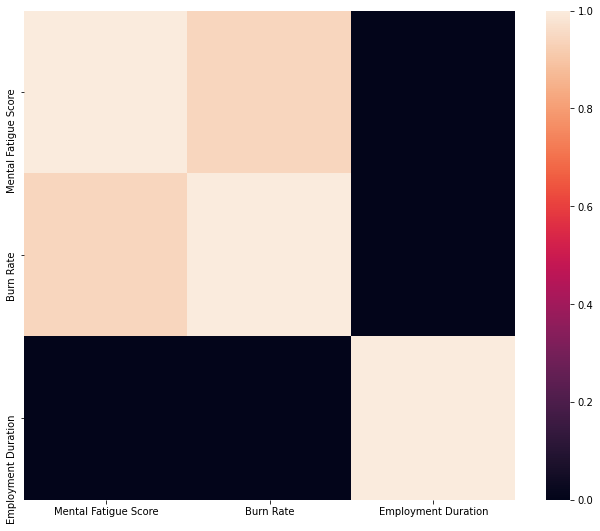

In [34]:
#Correlation Matrix

cor = df.corr()
cor
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(cor)

In [35]:
cor

Mental Fatigue Score  Burn Rate  Employment Duration
Mental Fatigue Score              1.000000   0.944389            -0.000037
Burn Rate                         0.944389   1.000000            -0.000309
Employment Duration              -0.000037  -0.000309             1.000000

In [36]:
# Resource Allocation and Mental Fatigue Score are highly correlated, so we will drop one column

# df.drop('Resource Allocation',axis=1,inplace=True)

df.drop('Employment Duration',axis=1,inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18590 entries, 0 to 22749
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                18590 non-null  category
 1   Company Type          18590 non-null  category
 2   WFH Setup Available   18590 non-null  category
 3   Designation           18590 non-null  category
 4   Resource Allocation   18590 non-null  category
 5   Mental Fatigue Score  18590 non-null  float64 
 6   Burn Rate             18590 non-null  float64 
dtypes: category(5), float64(2)
memory usage: 527.3 KB


In [38]:
# Checking if it still contains any missing Values
df.isnull().sum().value_counts()

0    7
dtype: int64

#### Dummy Variable Creation

Converting Categorical/Object into Numerical Variable

In [39]:
# One Hot Encoding
# Convert categorical variables to numerical

df=pd.get_dummies(df, columns=["Gender"])
df=pd.get_dummies(df, columns=["Company Type"])
df=pd.get_dummies(df, columns=["WFH Setup Available"])
df=pd.get_dummies(df, columns=["Designation"])
df=pd.get_dummies(df, columns=["Resource Allocation"])

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18590 entries, 0 to 22749
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Mental Fatigue Score      18590 non-null  float64
 1   Burn Rate                 18590 non-null  float64
 2   Gender_Female             18590 non-null  uint8  
 3   Gender_Male               18590 non-null  uint8  
 4   Company Type_Product      18590 non-null  uint8  
 5   Company Type_Service      18590 non-null  uint8  
 6   WFH Setup Available_No    18590 non-null  uint8  
 7   WFH Setup Available_Yes   18590 non-null  uint8  
 8   Designation_0.0           18590 non-null  uint8  
 9   Designation_1.0           18590 non-null  uint8  
 10  Designation_2.0           18590 non-null  uint8  
 11  Designation_3.0           18590 non-null  uint8  
 12  Designation_4.0           18590 non-null  uint8  
 13  Designation_5.0           18590 non-null  uint8  
 14  Resour

<AxesSubplot:>

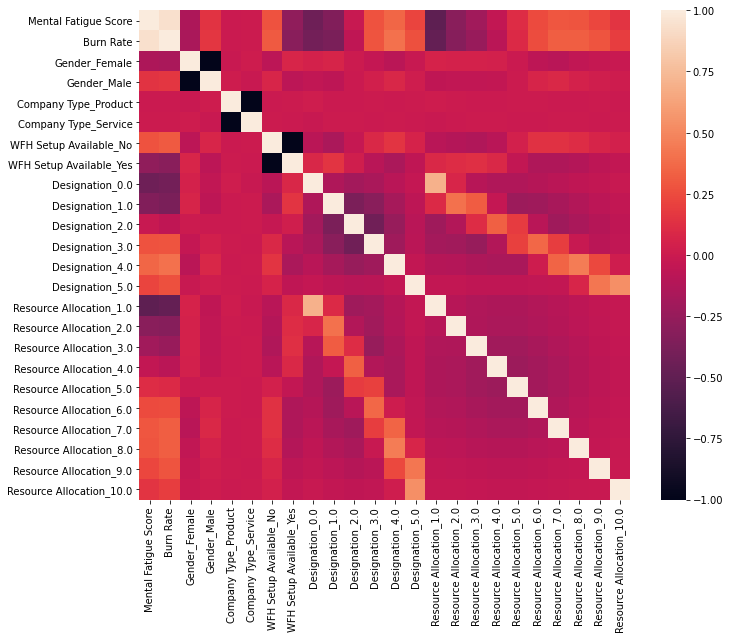

In [41]:
#Correlation Matrix of new dataframe

cor = df.corr()
cor
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(cor)

In [42]:
cor

Mental Fatigue Score  Burn Rate  Gender_Female  \
Mental Fatigue Score                  1.000000   0.944389      -0.145760   
Burn Rate                             0.944389   1.000000      -0.156577   
Gender_Female                        -0.145760  -0.156577       1.000000   
Gender_Male                           0.145760   0.156577      -1.000000   
Company Type_Product                 -0.004697  -0.005904      -0.009289   
Company Type_Service                  0.004697   0.005904       0.009289   
WFH Setup Available_No                0.277683   0.307168      -0.073718   
WFH Setup Available_Yes              -0.277683  -0.307168       0.073718   
Designation_0.0                      -0.430462  -0.406542       0.049207   
Designation_1.0                      -0.348857  -0.378232       0.068400   
Designation_2.0                      -0.022060  -0.057222       0.004775   
Designation_3.0                       0.278458   0.281395      -0.033115   
Designation_4.0                       0.356810   0.405504      -0.083662   
Designation_5.0                       0.219247   0.268975      -0.017644   
Resource Allocation_1.0              -0.510675  -0.478655       0.055617   
Resource Allocation_2.0              -0.310490  -0.327562       0.049019   
Resource Allocation_3.0              -0.199543  -0.237767       0.053723   
Resource Allocation_4.0              -0.043316  -0.080415       0.044721   
Resource Allocation_5.0               0.113096   0.095773      -0.005817   
Resource Allocation_6.0               0.245869   0.252224      -0.065624   
Resource Allocation_7.0               0.292871   0.324994      -0.086300   
Resource Allocation_8.0               0.282117   0.324734      -0.051776   
Resource Allocation_9.0               0.233845   0.281336      -0.028816   
Resource Allocation_10.0              0.153993   0.192918      -0.013061   

                          Gender_Male  Company Type_Product  \
Mental Fatigue Score         0.145760             -0.004697   
Burn Rate                    0.156577             -0.005904   
Gender_Female               -1.000000             -0.009289   
Gender_Male                  1.000000              0.009289   
Company Type_Product         0.009289              1.000000   
Company Type_Service        -0.009289             -1.000000   
WFH Setup Available_No       0.073718             -0.000756   
WFH Setup Available_Yes     -0.073718              0.000756   
Designation_0.0             -0.049207              0.015760   
Designation_1.0             -0.068400             -0.003222   
Designation_2.0             -0.004775             -0.002075   
Designation_3.0              0.033115              0.001014   
Designation_4.0              0.083662             -0.007010   
Designation_5.0              0.017644              0.000518   
Resource Allocation_1.0     -0.055617              0.010516   
Resource Allocation_2.0     -0.049019              0.004151   
Resource Allocation_3.0     -0.053723             -0.005380   
Resource Allocation_4.0     -0.044721             -0.006169   
Resource Allocation_5.0      0.005817              0.002932   
Resource Allocation_6.0      0.065624              0.001996   
Resource Allocation_7.0      0.086300             -0.004199   
Resource Allocation_8.0      0.051776             -0.003695   
Resource Allocation_9.0      0.028816              0.002608   
Resource Allocation_10.0     0.013061             -0.000331   

                          Company Type_Service  WFH Setup Available_No  \
Mental Fatigue Score                  0.004697                0.277683   
Burn Rate                             0.005904                0.307168   
Gender_Female                         0.009289               -0.073718   
Gender_Male                          -0.009289                0.073718   
Company Type_Product                 -1.000000               -0.000756   
Company Type_Service                  1.000000                0.000756   
WFH Setup Available_No         

In [43]:
# Drop column that has NaN in the corr matrix

#df.drop('Designation_0.0',axis=1,inplace=True)
#df.drop('Designation_4.0',axis=1,inplace=True)
#df.drop('Designation_5.0',axis=1,inplace=True)

In [44]:
df.head(2)

Mental Fatigue Score  Burn Rate  Gender_Female  Gender_Male  \
0                   3.8       0.16              1            0   
1                   5.0       0.36              0            1   

   Company Type_Product  Company Type_Service  WFH Setup Available_No  \
0                     0                     1                       1   
1                     0                     1                       0   

   WFH Setup Available_Yes  Designation_0.0  Designation_1.0  ...  \
0                        0                0                0  ...   
1                        1                0                1  ...   

   Resource Allocation_1.0  Resource Allocation_2.0  Resource Allocation_3.0  \
0                        0                        0                        1   
1                        0                        1                        0   

   Resource Allocation_4.0  Resource Allocation_5.0  Resource Allocation_6.0  \
0                        0                        0                        0   
1                        0                        0                        0   

   Resource Allocation_7.0  Resource Allocation_8.0  Resource Allocation_9.0  \
0                        0                        0                        0   
1                        0                        0                        0   

   Resource Allocation_10.0  
0                         0  
1                         0  

[2 rows x 24 columns]

In [45]:
#Normalize the columns

#max_value = df['Employment Duration'].max()
#min_value = df['Employment Duration'].min()
#df['Employment Duration'] = (df['Employment Duration'] - min_value) / (max_value - min_value)

#max_value = df['Mental Fatigue Score'].max()
#min_value = df['Mental Fatigue Score'].min()
#df['Mental Fatigue Score'] = (df['Mental Fatigue Score'] - min_value) / (max_value - min_value)

# Dropping for beter accuracy, since company type has minimal correlation to burn rate
df.drop('Company Type_Product',axis=1,inplace=True)
df.drop('Company Type_Service',axis=1,inplace=True)

In [46]:
#Save the final dataframe for modelling
df.to_csv("C:\Data Science\Competitions\Burnout_Rate_Prediction\dataset\\df_final.csv", index=False)

#### Model Building

In [47]:
#Splitting the data
feature_columns = df.columns.difference( ['Burn Rate'] )
train_X, test_X, train_y, test_y = train_test_split(df[feature_columns],
                                                  df['Burn Rate'],
                                                  test_size=0.00025, #0.001
                                                  random_state=125)
print (len( train_X ))
print (len (train_y))
print (len( test_X))
print (len( test_y))
print (df.shape)

18585
18585
5
5
(18590, 22)


#### Linear Regression

In [48]:
# Method 1
clf_linear= LinearRegression()
clf_linear.fit(train_X, train_y)
y_pred_linear=clf_linear.predict(test_X)

#Test Data
acc_linear=round(clf_linear.score(test_X,test_y) * 100, 2) 
print ('score:'+str(acc_linear) + ' percent') 

# Printing values
print('Slope:' ,clf_linear.coef_)
print('Intercept:', clf_linear.intercept_)

score:92.84 percent
Slope: [ 7.97036662e+10  7.97036662e+10  7.97036662e+10  7.97036662e+10
  7.97036662e+10  7.97036662e+10  5.23665522e+11  5.23665522e+11
  7.55558816e-02 -3.86324349e+11 -3.86324349e+11 -3.86324349e+11
 -3.86324349e+11 -3.86324349e+11 -3.86324349e+11 -3.86324349e+11
 -3.86324349e+11 -3.86324349e+11 -3.86324349e+11 -3.31820978e+11
 -3.31820978e+11]
Intercept: 114776138556.32187


In [49]:
print ('MSE:{}'.format(mse(y_pred_linear,test_y)))
print ('R Sqr:{}'.format(r2(test_y,y_pred_linear)))

MSE:0.002116129800379277
R Sqr:0.9283736189960982


#### Random Forest Regressor

In [50]:
clf_rf= RandomForestRegressor(n_estimators=200)
clf_rf.fit(train_X, train_y)
y_pred_rf= clf_rf.predict(test_X)
acc_rf = round( clf_rf.score(test_X,test_y) * 100, 2)
print (str(acc_rf) + ' percent')

90.65 percent


In [51]:
print ('MSE:{}'.format(mse(y_pred_rf,test_y)))
print ('R Sqr:{}'.format(r2(test_y,y_pred_rf)))

MSE:0.0027611916061267513
R Sqr:0.9065396829770258


#### Bagging Regressor

In [52]:
model_bg = BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))
model_bg.fit(train_X, train_y)
y_pred_bg = model_bg.predict(test_X)
acc_bg = round( model_bg.score(test_X, test_y) * 100, 2)
print (str(acc_bg) + ' percent')

91.36 percent


In [53]:
print ('MSE:{}'.format(mse(y_pred_bg,test_y)))
print ('R Sqr:{}'.format(r2(test_y,y_pred_bg)))

MSE:0.0025525968937270653
R Sqr:0.9136001592970802


#### Decision Tree Regressor

In [54]:
clf_dt=DecisionTreeRegressor()
clf_dt.fit(train_X, train_y)
y_pred_dt= clf_dt.predict(test_X)
acc_dt = round( clf_dt.score(test_X, test_y) * 100, 2)
print (str(acc_dt) + ' percent')

90.93 percent


In [55]:
print ('MSE:{}'.format(mse(y_pred_dt,test_y)))
print ('R Sqr:{}'.format(r2(test_y,y_pred_dt)))

MSE:0.0026794980319699907
R Sqr:0.9093048323866101


#### 4. XGBoost Algorithm

In [56]:
# Normal XGBoost with default parameters

xgb = xgboost.XGBRegressor()
xgb.fit(train_X, train_y)
#xgb.fit(df[feature_columns], df['Burn Rate']) # whole dataset
y_pred=xgb.predict(test_X)
acc_xg = round( xgb.score(test_X, test_y) * 100, 2)
print (str(acc_xg) + ' percent')

92.24 percent


#### Feature Importance - XGBoost

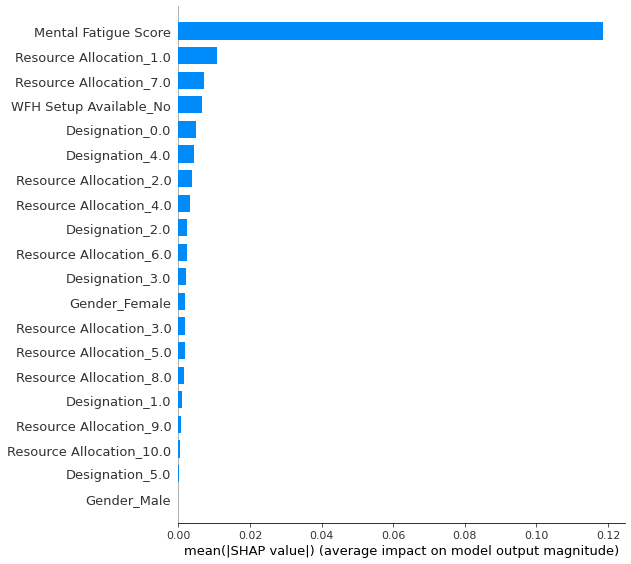

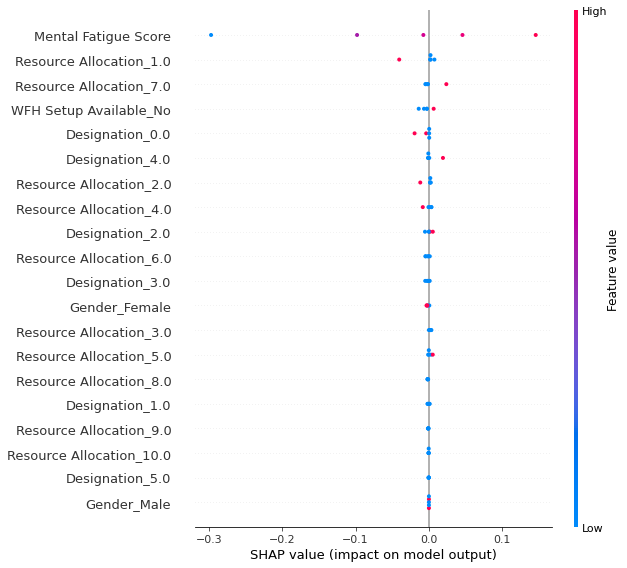

In [57]:
#The third method to compute feature importance in Xgboost is to use SHAP package. 
#It is model-agnostic and using the Shapley values from game theory to estimate the how does each feature contribute to the prediction.
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X, plot_type="bar")
shap.summary_plot(shap_values, test_X)

In [58]:
# Hypertune XGBoost
# To improve, reduce max depth to 3, increase estimators to 1600 = 89.13%

model = xgboost.XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [0.01], 
              'max_depth': [5],
              'min_child_weight': [3],
              'subsample': [1],
              'colsample_bytree': [1], 
              'booster' : ['gbtree'],
              'n_estimators': [1500]} 

model = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=False) 

In [59]:
model.fit(train_X, train_y)
y_pred=model.predict(test_X)
acc_xg = round( model.score(test_X, test_y) * 100, 2)
print (str(acc_xg) + ' percent')

92.94 percent


In [60]:
print ('MSE:{}'.format(mse(y_pred,test_y)))
print ('R Sqr:{}'.format(r2(test_y,y_pred)))

MSE:0.0020867261380287452
R Sqr:0.9293688688725716


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


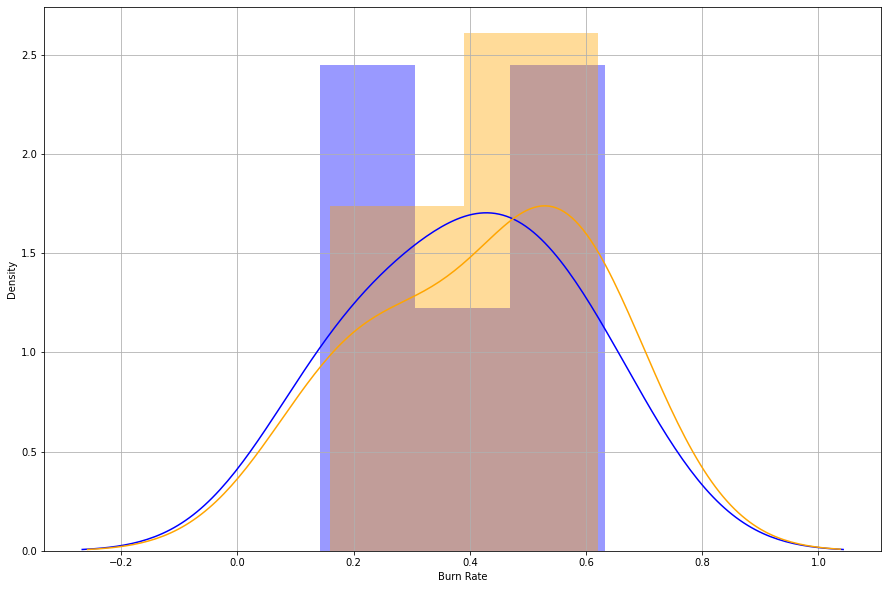

In [61]:
# Graphically plot the actual and predicted values for XGBoost
plt.figure(figsize=(15,10))
sns.distplot(y_pred,color="Blue")
sns.distplot(test_y,color="Orange")
plt.grid()
plt.show()

#### Gradient Boosting (GBM) Regressor

In [62]:
gbm_model= GradientBoostingRegressor(learning_rate=0.01,random_state=1)
gbm_model.fit(train_X, train_y)

y_pred=gbm_model.predict(test_X)
acc_gbm = round( gbm_model.score(test_X, test_y) * 100, 2)
print (str(acc_gbm) + ' percent')

78.35 percent


In [63]:
print ('MSE:{}'.format(mse(y_pred,test_y)))
print ('R Sqr:{}'.format(r2(test_y,y_pred)))

MSE:0.006396563796598151
R Sqr:0.7834902587124916


#### ADA Boost Regressor

In [64]:
ada_model = AdaBoostRegressor()
ada_model.fit(train_X, train_y)
#ada_model.score(test_X, test_y)

y_pred=ada_model.predict(test_X)
acc_abm = round( ada_model.score(test_X, test_y) * 100, 2)
print (str(acc_abm) + ' percent')

90.43 percent


In [65]:
print ('MSE:{}'.format(mse(y_pred,test_y)))
print ('R Sqr:{}'.format(r2(test_y,y_pred)))

MSE:0.0028283467047527655
R Sqr:0.9042666292731937


#### Deep Neural Net Regressor

In [66]:
# First install tensorflow and keras
# pip install tensorflow==2.2 --user
# pip install keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [67]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the model :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2816      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 167,681
Trainable params: 167,681
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Train the model, can run epochs in multiples of 100
# Since we are not using this model, so I have set it to 1
NN_model.fit(train_X, train_y, epochs=1, batch_size=32, validation_split = 0.05)

552/552 [==============================] - 2s 3ms/step - loss: 0.0517 - mean_absolute_error: 0.0517 - val_loss: 0.0467 - val_mean_absolute_error: 0.0467


In [69]:
# Evaluate the NN model(Test)
scores = NN_model.evaluate(test_X, test_y, verbose=0)
print("%s: %.2f%%" % (NN_model.metrics_names[1], scores[1]*100))

mean_absolute_error: 3.34%


In [70]:
# Evaluate the NN model(Train)
scores = NN_model.evaluate(train_X, train_y, verbose=0)
print("%s: %.2f%%" % (NN_model.metrics_names[1], scores[1]*100))

mean_absolute_error: 4.49%


In [71]:
# Serialize NN model to JSON
NN_model_json = NN_model.to_json()
with open("C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\NN_model.json", "w") as json_file:
    json_file.write(NN_model_json)
# serialize weights to HDF5
NN_model.save_weights("C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\NN_model.h5")
print("Saved Neural Net model to disk")

Saved Neural Net model to disk


#### Comparing Models

Let's compare the accuracy score of all the regression models used above.


In [72]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Decision Tree', 'Random Forest', "XGBoost", "Gradient Boosting", "ADA Boost", "Bagging Regressor"],    
    'Score': [acc_linear,acc_dt,acc_rf,acc_xg,acc_gbm,acc_abm,acc_bg]
    })

models.sort_values(by='Score', ascending=False)

Model  Score
3            XGBoost  92.94
0  Linear Regression  92.84
6  Bagging Regressor  91.36
1      Decision Tree  90.93
2      Random Forest  90.65
5          ADA Boost  90.43
4  Gradient Boosting  78.35

In [73]:
# Save the model to file in the current working directory

Pkl_Filename = "C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\xgb_model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

#### Feature Importance

In [74]:
# Using Random Forest
ce=pd.DataFrame(clf_rf.feature_importances_, train_X.columns)
ce.columns=['Coefficients']
ce.sort_values('Coefficients',ascending=False,inplace=True)
ce['Coefficients']=((ce['Coefficients'])*100).round(2)
ce=ce.head(25)
#ce.to_excel(writer,'Variable_imp',index=True)
ce

Coefficients
Mental Fatigue Score             95.47
Designation_4.0                   0.38
Resource Allocation_7.0           0.37
WFH Setup Available_Yes           0.32
Resource Allocation_6.0           0.30
Resource Allocation_3.0           0.29
Resource Allocation_8.0           0.28
Resource Allocation_1.0           0.24
Resource Allocation_2.0           0.24
Resource Allocation_9.0           0.23
Resource Allocation_5.0           0.22
WFH Setup Available_No            0.21
Resource Allocation_4.0           0.20
Gender_Female                     0.20
Gender_Male                       0.20
Designation_3.0                   0.19
Designation_2.0                   0.18
Designation_1.0                   0.17
Designation_5.0                   0.16
Resource Allocation_10.0          0.08
Designation_0.0                   0.05

<AxesSubplot:>

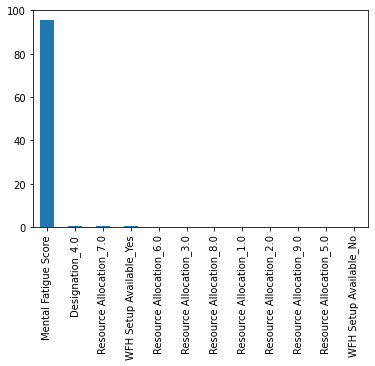

In [75]:
ce=ce.head(12)
ce.Coefficients.plot(kind='bar')

#### Predict for the test file

In [76]:
test_df = pd.read_csv("C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\test.csv")

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


Employment Duration     0.0
Mental Fatigue Score    0.0
Resource Allocation     0.0
Designation             0.0
WFH Setup Available     0.0
Company Type            0.0
Gender                  0.0
Employee ID             0.0
dtype: float64


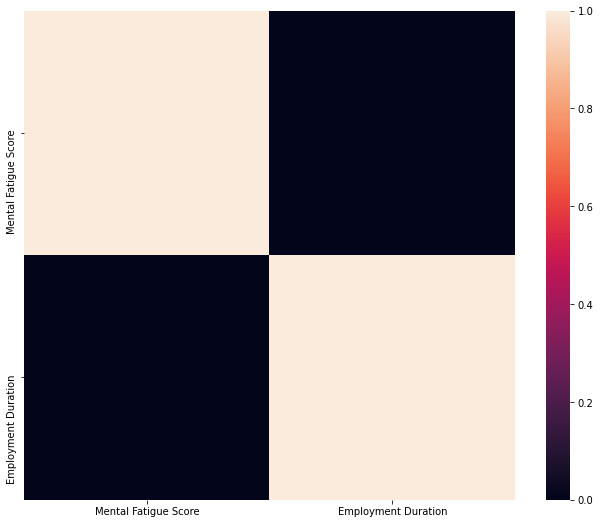

In [77]:
# Prepare "test_df" like the original dataframe

# Convert to datetime column
test_df[["Date of Joining"]] = test_df[["Date of Joining"]].apply(pd.to_datetime)

# Subtract from today and create a new column 'Employment Duration'
dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
test_df['Employment Duration'] = dt - pd.to_datetime( test_df['Date of Joining'])

test_df.drop('Date of Joining',axis=1,inplace=True)

#Extract the number of days from timedelta64 object
test_df['Employment Duration'] = test_df['Employment Duration'].astype('timedelta64[D]')

# Employee ID is irrelevant data for linear regression, so dropping the variable.
# test_df.drop('Employee ID',axis=1,inplace=True)

# Convert into categorical variables

test_df['Designation'] = test_df['Designation'].astype('category')
test_df['Gender'] = test_df['Gender'].astype('category')
test_df['Company Type'] = test_df['Company Type'].astype('category')
test_df['WFH Setup Available'] = test_df['WFH Setup Available'].astype('category')
test_df['Resource Allocation'] = test_df['Resource Allocation'].astype('category')

test_df.columns[test_df.isnull().any()]
missing(test_df)

# Correlation Matrix

cor = test_df.corr()
cor
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(cor)
cor

# Resource Allocation and Mental Fatigue Score are highly correlated, so we will drop one column
# test_df.drop('Resource Allocation',axis=1,inplace=True)

test_df.drop('Employment Duration',axis=1,inplace=True)

# One Hot Encoding
# Convert categorical variables to numerical

test_df=pd.get_dummies(test_df, columns=["Gender"])
test_df=pd.get_dummies(test_df, columns=["Company Type"])
test_df=pd.get_dummies(test_df, columns=["WFH Setup Available"])
test_df=pd.get_dummies(test_df, columns=["Designation"])
test_df=pd.get_dummies(test_df, columns=["Resource Allocation"])

#test_df.drop('Designation_0.0',axis=1,inplace=True)
#test_df.drop('Designation_4.0',axis=1,inplace=True)
#test_df.drop('Designation_5.0',axis=1,inplace=True)

# Dropping for beter accuracy, since company type has minimal correlation to burn rate
test_df.drop('Company Type_Product',axis=1,inplace=True)
test_df.drop('Company Type_Service',axis=1,inplace=True)

In [78]:
test_df.shape

(12250, 22)

In [79]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12250 entries, 0 to 12249
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Employee ID               12250 non-null  object 
 1   Mental Fatigue Score      12250 non-null  float64
 2   Gender_Female             12250 non-null  uint8  
 3   Gender_Male               12250 non-null  uint8  
 4   WFH Setup Available_No    12250 non-null  uint8  
 5   WFH Setup Available_Yes   12250 non-null  uint8  
 6   Designation_0.0           12250 non-null  uint8  
 7   Designation_1.0           12250 non-null  uint8  
 8   Designation_2.0           12250 non-null  uint8  
 9   Designation_3.0           12250 non-null  uint8  
 10  Designation_4.0           12250 non-null  uint8  
 11  Designation_5.0           12250 non-null  uint8  
 12  Resource Allocation_1.0   12250 non-null  uint8  
 13  Resource Allocation_2.0   12250 non-null  uint8  
 14  Resour

In [80]:
test_df[test_df.columns[test_df.columns!='Employee ID'] ]

Mental Fatigue Score  Gender_Female  Gender_Male  \
0                       7.7              1            0   
1                       5.2              1            0   
2                       5.9              0            1   
3                       4.6              1            0   
4                       6.4              1            0   
...                     ...            ...          ...   
12245                   6.1              1            0   
12246                   5.9              1            0   
12247                   9.6              0            1   
12248                   6.7              0            1   
12249                   2.0              1            0   

       WFH Setup Available_No  WFH Setup Available_Yes  Designation_0.0  \
0                           1                        0                0   
1                           0                        1                0   
2                           0                        1                0   
3                           1                        0                0   
4                           1                        0                0   
...                       ...                      ...              ...   
12245                       0                        1                0   
12246                       0                        1                0   
12247                       1                        0                0   
12248                       1                        0                0   
12249                       1                        0                0   

       Designation_1.0  Designation_2.0  Designation_3.0  Designation_4.0  \
0                    0                1                0                0   
1                    1                0                0                0   
2                    1                0                0                0   
3                    0                0                1                0   
4                    0                1                0                0   
...                ...              ...              ...              ...   
12245                1                0                0                0   
12246                0                1                0                0   
12247                0                0                0                1   
12248                0                0                1                0   
12249                0                1                0                0   

       ...  Resource Allocation_1.0  Resource Allocation_2.0  \
0      ...                        0                        0   
1      ...                        0                        1   
2      ...                        0                        0   
3      ...                        0                        0   
4      ...                        0                        0   
...    ...                      ...                      ...   
12245  ...                        0                        1   
12246  ...                        0                        0   
12247  ...                        0                        0   
12248  ...                        0                        0   
12249  ...                        0                        1   

       Resource Allocation_3.0  Resource Allocation_4.0  \
0                            0                        0   
1                            0                        0   
2                            1                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
12245                        0                        0   
12246                        0                        1   
12247                        0                        0   
12248                        0                        0   
12249                        0                        

In [81]:
# Reorder the columns in test_df as per test_X , otherwise it throws an error
# Keep the Employee Id column in the test_df 

test_df = pd.concat([test_df['Employee ID'], test_df[test_X.columns]], axis=1)

In [82]:
# Run predictions on test_df

y_pred=model.predict(test_df[test_df.columns[test_df.columns!='Employee ID']]) 
print(y_pred) 

[0.61191124 0.35900104 0.42885393 ... 0.8248215  0.5765572  0.12905547]


In [83]:
# Create a dataframe with 'Employee ID' and the predicted value
# Give the column name as 'Burn Rate'

columns = ['Burn Rate']
y_pred = pd.DataFrame(y_pred,columns=columns)
res = pd.concat([test_df['Employee ID'],y_pred], axis=1)

In [84]:
# Round the value to 2 decimal places
# Not rounding off for better accuracy
# res['Burn Rate'] = res['Burn Rate'].round(decimals=2)
res.head(5)

Employee ID  Burn Rate
0  fffe31003300390039003000   0.611911
1  fffe31003300310037003800   0.359001
2  fffe33003400380035003900   0.428854
3      fffe3100370039003200   0.375591
4  fffe32003600390036003700   0.534027

In [85]:
# Save the final predictions file
res.to_csv('C:\\Data Science\\Competitions\\Burnout_Rate_Prediction\\dataset\\submission.csv', index=False)